# K-Means , Agglomerative and DBSCAN on Amazon Fine Food Reviews DataSet:

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

##### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

###### Number of reviews: 568,454
###### Number of users: 256,059
###### Number of products: 74,258
###### Timespan: Oct 1999 - Oct 2012
###### Number of Attributes/Columns in data: 10

###### Attribute Information:

###### Id - Id of the row in the dataset
###### ProductId - unique identifier for the product
###### UserId - unqiue identifier for the user
###### ProfileName - name on the profile
###### HelpfulnessNumerator - number of users who found the review helpful
###### HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
###### Score - rating between 1 and 5
###### Time - timestamp for the review
###### Summary - brief summary of the review
###### Text - text of the review
###### Objective:
######  To apply the K-Means Clustering Algorithm on the Bow , TF-IDF Vectors and computing the best K value for each Vectors and finding the word cloud for each clusters formed .

## K-Means Clustering:

1. Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)
2. Once after you find the k clusters, plot the word cloud per each cluster so that at a single go we can analyze the words in a cluster.
3. Also apply the k-medoids algorithm as well.

### Step-By-Step procedure

1. In this, we need to work with all 4-vectorizers (BOW, TFIDF,Avg w2v and TF-IDF weighted w2v) where we will convert our texted review into numerical(vector) form in order to apply any Model on it.

2. After that we will take our cleandedtext(i.e cleand text means we have already cleaned our data by removing stops words, other this which are going to affect our model) and then we will take only test data not their respective class lable because as we know we are goint to apply K-means clustering algo which do not required class lables. what is does is it mainly group/clusters the similar data points

3. After that as we know K i.e n_clusters is not specified, the optimal number of clusters we need to estimate using a technique called the elbow method. The elbow method plots the loss and K(n_clusters). and try to get the best k. And as we know when k increae the loss will decrease, and the point where the loss is slightly change with direction then that will be our elbow point

4. After getting best k i.e n_clusters we will implemsnt k-means with best k(n_clusters) which we get using elbow method. And try to plot the reviews of each clusters in word cloud 

5. As we know plm with k-means is not interpretable so we will implement k-medoids and repeat 3 and 4 step

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

import sqlite3
import string
import nltk

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from tqdm import tqdm

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

# ============================== data preprocessing ===========================================
# Making the connection to the database.sqlite
con = sqlite3.connect("C:\\Users\\Ashu\\Desktop\\AAIC\\IPython Notebooks\\AMAZON Fine Food Reviews\\amazon-fine-food-reviews\\database.sqlite")





In [2]:
# Extracting out the positive and negative features 
amazon_featured_reviews = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3""" , con)

print(amazon_featured_reviews.shape)




# Creating the partition function returning the positive or negative reviews and appending them in the Score column in place 
# of ratings given:

def partition(x):
        if x < 3:
            return 0
        else :
            return 1
        
        
pos_neg_reviews_df = amazon_featured_reviews['Score'].map(partition)
print(type(pos_neg_reviews_df) , 'pos_neg_reviews_df' , pos_neg_reviews_df.shape)
print('type(amazon_featured_reviews):' , type(amazon_featured_reviews))
amazon_featured_reviews['Score'] = pos_neg_reviews_df
amazon_featured_reviews.shape
amazon_featured_reviews.head(2)


(525814, 10)
<class 'pandas.core.series.Series'> pos_neg_reviews_df (525814,)
type(amazon_featured_reviews): <class 'pandas.core.frame.DataFrame'>


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [3]:
# Data deduplication is used to clean the data having redundancy and many unwanted things which msut be removed to further
# use the data:

duplicate_df = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE !=3 AND Text IN 
                                    (SELECT Text FROM REVIEWS
                                    GROUP BY Text having count(*) > 1)
                                    """ , con)
duplicate_df.head(4)

#So we can see there are many such duplicated rows having some column values similar to each other

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
1,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
2,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
3,70,B000E7VI7S,AWCBF2ZWIN57F,C. Salcido,0,2,5,1185753600,pretzel haven!,this was sooooo deliscious but too bad i ate e...


In [4]:
#Doing some other check using the below query to see whether such reduncdancy is over small scale or a large scale of rows:
# From count(*) values we can see that we have so much of redundant data, so it has to be cleaned.
dup_data = pd.read_sql_query("""
select ID,ProductID,USERID , PROFILENAME , Summary ,text ,count(*) AS COUNT
FROM REVIEWS
GROUP BY PRODUCTID,SUMMARY,TEXT  
having count(*) > 1""",con)
dup_data.head(6)

,Id,ProductId,UserId,ProfileName,Summary,Text,COUNT
0,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
1,217385,7310172101,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
2,369857,B000084DWM,A3TVZM3ZIXG8YW,christopher hayes,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",10
3,369801,B000084DWM,A36JDIN9RAAIEC,Jon,"Great product, but trust your vet not the hype","I have two cats, one 6 and one 2 years old. Bo...",2
4,410265,B000084EZ4,A2FGXWWR8ZU59C,Thomas Lawrence,"Cats love the food, but no pull-tab top, and d...","I appreciate being able to buy this larger, mo...",2
5,410304,B000084EZ4,A29JUMRL1US6YP,HTBK,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,4


In [5]:
# Let's see another case:

dup_data = pd.read_sql_query("""SELECT * FROM REVIEWS
                                    WHERE SCORE != 3 AND UserId = "AJD41FBJD9010" AND ProductID="7310172001"
                                    Order by ProductID""" , con)
dup_data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,171152,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,dogs LOVE it-- best treat for rewards and tra...,Freeze dried liver has a hypnotic effect on do...
1,171153,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
2,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
3,171189,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",39,51,5,1233360000,NO waste at all ---- great for training ----...,Freeze dried liver has a hypnotic effect on do...
4,171223,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
5,171228,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",5,7,5,1233360000,NO waste at all--- all dogs love liver treats-...,Freeze dried liver has a hypnotic effect on do...


# Observation:

####    In above Analysis what we found is :
###### There are product's having the same productID's with same {'TEXT'} , {'Timestamp'} , {'UserID'}
###### There are products having the different productID's with same {'TEXT'} , {'Timestamp'} , {"helpfullnessNumerator"} , {"HelpfullnessNumerator"} 
##### We termed such type of the data in our data set as Redundant Data , so we perform various cleaning methods to remove them from
###### the Data Set.

In [6]:
#Removing the Duplicate data points:

duplicated_data = amazon_featured_reviews.duplicated(subset={'UserId','ProfileName','Time','Summary','Text'} , keep='first')
duplicated_data = pd.DataFrame(duplicated_data , columns=['Boolean'])
print(duplicated_data.head(5))

#True values in the Boolean Series represents the duplicate data:
print(duplicated_data['Boolean'].value_counts(dropna=False)) #gives me the total no of the duplicates

#The total no of duplicates here in the amazon_featured_reviews are:
print("total no of duplicates here in the amazon_featured_reviews are:",duplicated_data[duplicated_data['Boolean']==True].count())

#dropping the duplicates:
final = amazon_featured_reviews.sort_values(by='ProductId',kind='quicksort',ascending=True,inplace=False)
final = final.drop_duplicates(subset={'UserId','ProfileName','Time','Text'} , keep='first', inplace=False)
print('\n','DataFrame final shape before removing helpfullness data :', final.shape)

#Also removing the instances where HelpfulnessNumerator >= HelpfulnessDenominator:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('final', final.shape)


   Boolean
0    False
1    False
2    False
3    False
4    False
False    365333
True     160481
Name: Boolean, dtype: int64
total no of duplicates here in the amazon_featured_reviews are: Boolean    160481
dtype: int64

 DataFrame final shape before removing helpfullness data : (364173, 10)
final (364171, 10)


In [7]:
#Finding the books data in the amazon_featured_reviews using the regex:
import re
print(final.columns)
def analyzing_summary_book(filtered_data , regex):
    
    mask_summary = filtered_data.Summary.str.lower().str.contains(regex) 
    mask_text =    filtered_data.Text.str.lower().str.contains(regex)
    print(len(filtered_data[mask_summary].index) , len(filtered_data[mask_text].index))
    print('initial shape of the filtered_data' , filtered_data.shape)
    filtered_data.drop(filtered_data[mask_summary].index , inplace=True , axis=0)
    filtered_data.drop(filtered_data[mask_text].index , axis=0 , inplace=True)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [8]:
#Removing the Books reviews we get below final dataframe:
#On observation of some of the reviews we got certain keywords related to books,reading ,poems , story,learn , study , music 
#So we removed these words as much as possible:


print('final shape before removing books reviews:' , final.shape)
analyzing_summary_book(final , re.compile(r'reading|books|book|read|study|learn|poems|music|story'))

print('final shape after removing the book reviews:' , final.shape)

final shape before removing books reviews: (364171, 10)
2842 36649
initial shape of the filtered_data (364171, 10)
final shape after removing the book reviews: (326808, 10)


In [9]:
#Computing the proportion of positive and negative class labels in the DataFrame:
final['Score'].value_counts()

1    276668
0     50140
Name: Score, dtype: int64

In [10]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
print(stop)
print('\n' , 'length of stopwords set' , len(stop))

print("*" * 30)

sno = SnowballStemmer('english')

{'whom', 'couldn', 'both', 'yours', 'on', 'now', 'won', 'hers', 'how', 'any', 'i', 'the', 'over', 'most', 'above', 'by', 'had', 'own', 'and', 'was', 'doing', 's', 'weren', 'is', 'does', 'were', 'up', 'at', 'so', "you're", 'off', 'doesn', 'what', 'should', 'she', "don't", 'or', 'very', 'out', "shan't", 'if', 'themselves', 'each', 'between', 'its', 'yourself', 'hasn', 'our', 'as', 'further', 'some', 'this', "should've", "you'd", 'in', 'he', 'of', 'into', 'wouldn', 've', 'once', 'hadn', 'not', 'am', 'while', 'about', 'm', 'why', 'from', 'are', 'ourselves', 'all', 'a', "she's", "isn't", "needn't", 'have', 'his', 'with', "that'll", 'herself', 'below', 'under', 'to', 'yourselves', 'it', "won't", 'them', 'down', 'only', 'wasn', 'other', 'those', 'no', 'just', 'o', "didn't", 'aren', 'can', 'before', 'myself', 'here', 'nor', 'too', 'will', "mustn't", 'haven', 'you', 'ours', 'through', "wouldn't", "hasn't", 'shouldn', 'same', 'himself', 'my', 'did', 'until', 't', "wasn't", 'having', 'for', 'but'

# Observation:
#### We found many redundancy in the data set and some of the Books data which does not make any sense here.
##### We dropped the almost 160K records in data de duplication step.

# Text Preprocessing : 
### Removing Removing html tags
### Removing Punctuation charcaters
### Alphanumeric numbers 
### Length of words must be > 2  
### Uppercase to Lowercase
### Removing the stop words
### Using the Snowball Stemmer.  

In [11]:
# Functions to clean the html tags and punctuation marks using Regular Expression.

def clean_htmlTags(sentence):
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern , '' , sentence)
    return cleaned_text

def clean_punc(sentence):
    cleaned = re.sub(r'[!|#|,|?|\'|"]' , r' ' , sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]' ,r' ' , cleaned)
    return cleaned


In [12]:
#The below code will remove all the html tags , punctuation marks , uppercase to lowercase conversion only if length of the words
# are greater than 2 and are alphanumeric . Further we perform the Stemming of the each word in the each document.

all_positive_words = []
all_negative_words = []
i = 0
str_temp = ' '
final_string = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = clean_htmlTags(sent)
    for w in sent.split():
        for clean_word in clean_punc(w).split():
            if((clean_word.isalpha()) and (len(clean_word) > 2)):
                if(clean_word.lower() not in stop):
                    s = (sno.stem(clean_word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if((final['Score'].values)[i] == 'positive'):
                        all_positive_words.append(s)
                    if((final['Score'].values)[i] == 'negative'):
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue

    str_temp = b" ".join(filtered_sentence)
    final_string.append(str_temp)
    i+=1

In [13]:
#Now I have a final_string of list of each review and append it to the new columns of the final data frame:

final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')
final.shape


(326808, 11)

In [14]:
#Making backup of th pre processed data for the future use:
final_backup = final

In [15]:

final_backup.shape #to use the dataframe in future if required

(326808, 11)

In [67]:
#Now lets take roughly same proportion of  each of positive and negative review from the data set for faster processing 
#the further data:
#We can process our next tasks with whole amount of the data but we are bounded with time and memory spaces so we have used


# To sample 80K points :

final_clean = final.iloc[:100000:]
print(final_clean.shape)
print(final_clean['Score'].value_counts())


(100000, 11)
1    85464
0    14536
Name: Score, dtype: int64


In [68]:
#Sort the final data frame by timestamp values:
final_clean['Time'] = pd.to_datetime(final['Time'],unit='s')
final_clean = final_clean.sort_values(by='Time')
final_clean.shape

(100000, 11)

#### BAG OF WORDS:


In [69]:
# Creating the training data :
X = final_clean['CleanedText']
y = final_clean['Score']
print(X.shape , y.shape)


(100000,) (100000,)


In [70]:
# Computing the Train Vectorizer :
count_vect = CountVectorizer(ngram_range=(1,1) , min_df=10)
X_bow = count_vect.fit_transform(X)
print(X_bow.shape)
type(X_bow)

(100000, 7841)


scipy.sparse.csr.csr_matrix

## K-Medoids Algorithm Implementation:
#### This function returns M , C where M is the index of central review of cluster and C is dictionary of all the reviews belonging to particular cluster label.

In [71]:
#The code is taken from the github repo: https://raw.githubusercontent.com/letiantian/kmedoids/master/kmedoids.py
import random

def kMedoid(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('So many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C


## K-Means Hyperparameter Tuning:
#### Find the best ‘k’ using the elbow-knee method (plotting k vs cluster.KMeans.inertia_)

In [72]:
from sklearn.cluster import KMeans

n_clusters_list = range(1,10)
cluster_inertia = []

for clusters in tqdm(n_clusters_list):
    model = KMeans(n_clusters = clusters, n_init=5 , n_jobs=-1)
    model.fit(X_bow)
    cluster_inertia.append(model.inertia_)

100%|████████████████████████████████████████| 9/9 [3:42:50<00:00, 1965.36s/it]


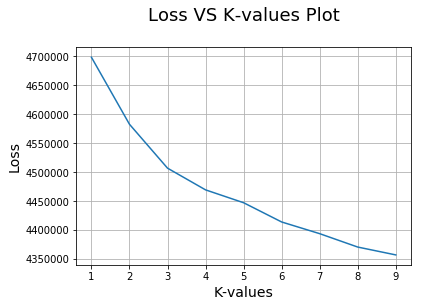

In [73]:
# Draw Loss VS K values plot
plt.plot(n_clusters_list, cluster_inertia)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

#### After finding the optimal value of K we will compute the WordCloud plot for the BoW:

In [74]:
optimal_n_clusters = 3

# Implementing K-Means using optimal value of n_clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, n_jobs=-1).fit(X_bow)


In [75]:
# getting original text i.e review column from the dataset 
text_reviews = final['Text'].values
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(text_reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(text_reviews[i])
    else :
        cluster_3.append(text_reviews[i]) 

# Ploting the word cloud per each cluster so that we can analyze the words in a cluster.
### Cluster - 1  

In [76]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def cluster_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stopwords ,background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Amazon Review - 1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!
****************************************************************************************************


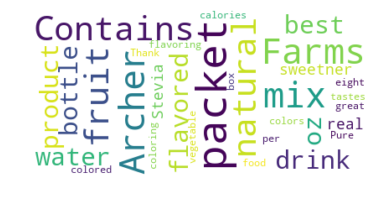

Amazon Review - 2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
****************************************************************************************************


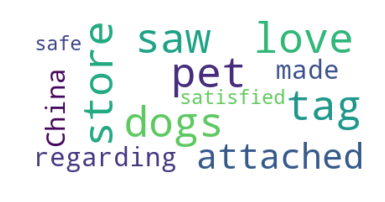

Amazon Review - 3
My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
****************************************************************************************************


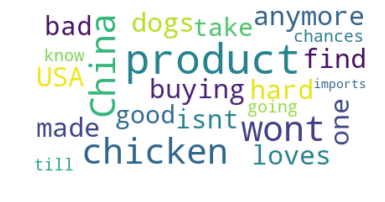

In [77]:
#We will print the 3 reviews in our wordcloud for each cluster:
counter = 1;
for i in range(len(cluster_1)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_1[i])
        print("*"*100)
        cluster_wordcloud(cluster_1[i])
    counter +=1

### Cluster - 2 reviews

Amazon Review - 1
I have a chihuahua that is the pickiest eater in the world!  I could not find any treat that this dog liked.  I finally tried the Pro-Treat Liver treats for dogs and she loves them!!  I actually have to give them to her at different times on different days, or she will get use to when she will get them.  Example, I was giving them to her when I got up every morning, so every morning she would wake me up at like 3:00 am so she could have a treat!<br /><br />These are the best treats and they are good for her!  It's a win win situation!
****************************************************************************************************


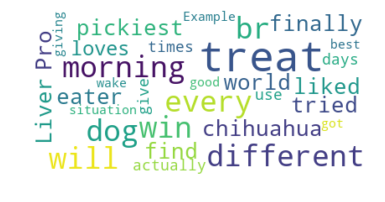

Amazon Review - 2
We have used Pro-Treat Beef Liver, Freeze Dried Dog Treats for several years.  It's our 110 lb. hound's favorite treat and great to use for training. It's a fairly expensive treat but if used properly lasts quite a while. I would definitely recommend.
****************************************************************************************************


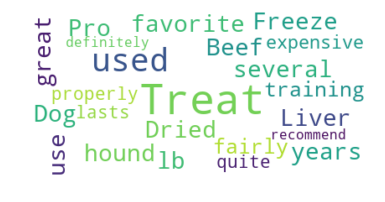

Amazon Review - 3
Otter and I are very happy with this product. I am happy to have come across this dealer on line, because it was the best deal with respect to cost and convenience.
****************************************************************************************************


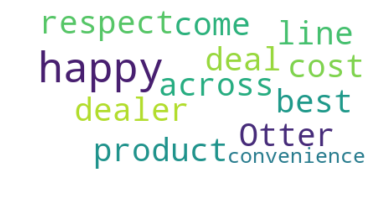

In [78]:
#We will print the 3 reviews in our wordcloud for each cluster:
counter = 1;
for i in range(len(cluster_2)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_2[i])
        print("*"*100)
        cluster_wordcloud(cluster_2[i])
    counter +=1

### Cluster - 3 reviews

Amazon Review - 1
Our two dogs love this product, and we love the fact that it's not loaded with chemical preservatives and fillers.  The fact that the pieces are irregular is not a drawback and is not surprising.  I do cut up the larger pieces as I don't want to give them too much at once.  The prospect of getting one of these treats makes them much more receptive to training and just coming when you call.  Also, we find the largest size very economical as you don't pay for shipping.
****************************************************************************************************


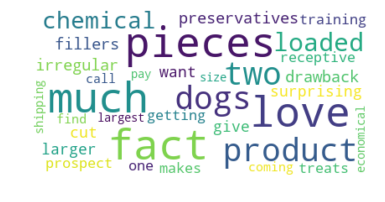

Amazon Review - 2
My dogs love this stuff! They will do anything for liver treats!<br />Be careful, very rich, a little goes a very long way, give sparingly!!!!
****************************************************************************************************


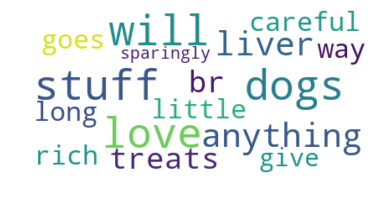

Amazon Review - 3
These Dried Dog Treats are great.  My dog was diagnoised with diabetes and these are a low fat treat for him and he loves them.
****************************************************************************************************


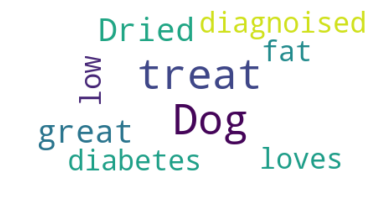

In [79]:
#We will print the 3 reviews in our wordcloud for each cluster:
counter = 1;
for i in range(len(cluster_3)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_3[i])
        print("*"*100)
        cluster_wordcloud(cluster_3[i])
    counter +=1

## k-medoids algorithm Implementation


In [80]:
# code reference https://github.com/letiantian/kmedoids
from sklearn.metrics.pairwise import pairwise_distances

X_bow_data = X_bow[0:10000,:]
D_matrix = pairwise_distances(X_bow_data , metric='euclidean')

M, C = kMedoid(D_matrix , k = optimal_n_clusters)

****************************************************************************************************
Cluster -  1
Printing the no of reviews present in each Cluster 1  are =  31
****************************************************************************************************
Review -  1
Dogs just love Freeze dried liver and this is a good price for this size container.


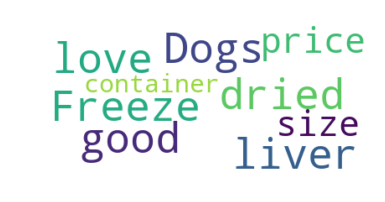

Review -  2
Put it out and it immediately started catching flies like crazy.  Love it. And the smell is not a problem.


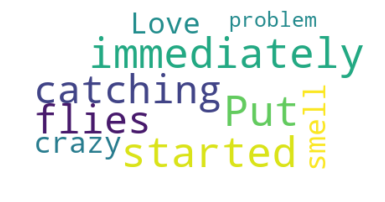



****************************************************************************************************
Cluster -  2
Printing the no of reviews present in each Cluster 2  are =  10
****************************************************************************************************
Review -  1
This type of trap is highly effective IF you do NOT follow the directions about how to place it. If you bury it (which the directions will tell you to do) it will simply NOT work. If your "out o sight" trap is out of sight it is TOO DEEP and all you will get is holes in your yard and perhaps an annoyed mole.<br /><br />When the very expensive exterminator (who we now refer to as "Mark the Mole Man") came to our house, I showed him our "out of sight" mole trap. He tried to be respectful but finally just said, "Ma'am, that's too deep. Ain't gonna kill nothin'." As it turns out, this is exactly the same type of trap he uses. He just knows how to use it correctly.<br /><br />He pulled it up and knocked

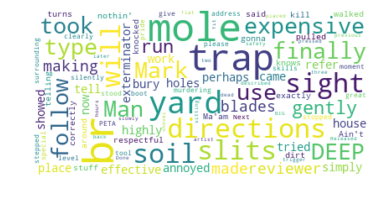

Review -  2
I bought these traps due to the good reviews and the price of the item.  I followed the directions of the guy that tells all of his mole stories which is pretty awesome and entertaining in the review section.  I set my traps and had my first Mole within a day!!  I thought my problems were solved but they came back and I got a second within a day!!  They then showed up in the front lawn and I didn't set the trap right and It took a few days to realize my mistake but after I reset the trap I got my third mole and I've been mole free for a couple of weeks!!!  I would encourage people to get this product.  It does take a decent amount of strength to set the traps but they work and thats all I care about.


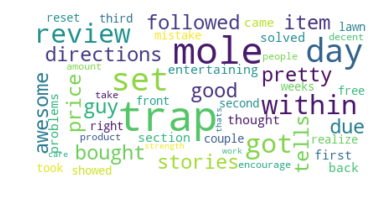



****************************************************************************************************
Cluster -  3
Printing the no of reviews present in each Cluster 3  are =  9959
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


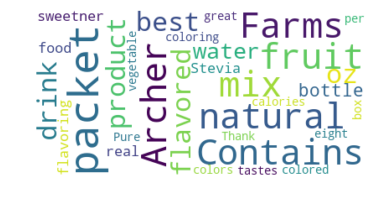

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


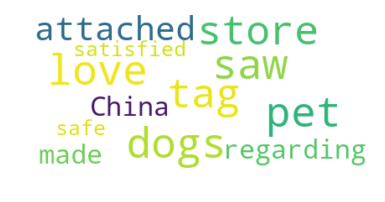

In [81]:
# Getting the reviews in all clusters
for labels in C:
    print("*" * 100)
    print("Cluster - ",labels + 1)
    print('Printing the no of reviews present in each Cluster',labels + 1,' are = ',C[labels].shape[0])
    print("*" * 100)

    review_counter = 1
    
    for label_index in C[labels]:
        if review_counter == 3:
            break;
        else:
            print('Review - ',review_counter)
            print(text_reviews[label_index])
            cluster_wordcloud(text_reviews[label_index])
            review_counter = review_counter+1
    print('\n')


# TF-idf vector using Dataset :

#### We will apply the K means clustering over the tfidf vectorizer and will print the reviews in each cluster:

In [82]:
#Uni Gram  Train dataset Tf-IDF Vector:
tfidf_vector = TfidfVectorizer(min_df=10 )
X_tfidf= tfidf_vector.fit_transform(X)

print('X_tfidf.get_shape() : ' , X_tfidf.get_shape())

X_tfidf.get_shape() :  (100000, 7841)


In [83]:
#Applying the Kmeans:
#Cluster_inertia_tfidf comprise of all centroids list.
n_clusters_list_tfidf = range(1,10)
cluster_inertia_tfidf = []

for clusters in tqdm(n_clusters_list_tfidf):
    model = KMeans(n_clusters = clusters, n_init=5 , n_jobs=-1)
    model.fit(X_tfidf)
    cluster_inertia_tfidf.append(model.inertia_)

100%|████████████████████████████████████████| 9/9 [7:58:42<00:00, 5452.97s/it]


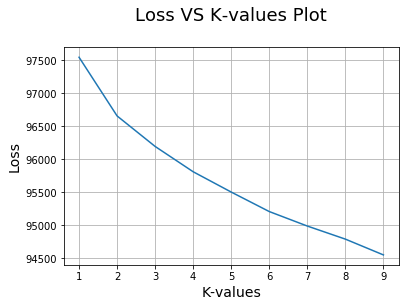

In [84]:
# Plotting the  Loss VS K values plot:
plt.plot(n_clusters_list_tfidf, cluster_inertia_tfidf)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

### K-Means Clustering implementation  with best n_clusters 

In [85]:
optimal_n_clusters_tfidf = 3

# Implementing K-Means using optimal value of n_clusters
kmeans_tfidf = KMeans(n_clusters=optimal_n_clusters_tfidf, n_jobs=-1).fit(X_tfidf)

# getting original text i.e review column from the dataset 
text_reviews = final['Text'].values
cluster_1_tfidf = []
cluster_2_tfidf = []
cluster_3_tfidf = []

#Adding the reviews to the corresponding the clusters:
for i in range(kmeans_tfidf.labels_.shape[0]):
    if kmeans_tfidf.labels_[i] == 0:
        cluster_1_tfidf.append(text_reviews[i])
    elif kmeans_tfidf.labels_[i] == 1:
        cluster_2_tfidf.append(text_reviews[i])
    else :
        cluster_3_tfidf.append(text_reviews[i])

## Ploting the word cloud per each cluster so that we can analyze the words in a cluster.
### Cluster - 1 review 

Amazon Review - 1
My dog has never stopped loving these treats for over a year.<br /><br />Service was great and shipping was prompt.
****************************************************************************************************


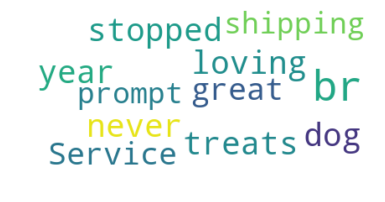

Amazon Review - 2
I recently saw the DVD 5.1 version of this film and it is excellent. The picture quality is, excuse the pun, picture perfect. The sound is very good on the surround but not much on dialog separation if any at all. But Alec Baldwin makes up for the rest. I have always told my partner that Alec would be the only guy in the world that i would leave him for.  I know it would never happen but each time i watch this movie my fantasy runs wild just like the movie itself.  This is just pure fun, pure entertainment, no thinking involved, no serious plot, no hardship, non racist, non potical just pure fun.  Get  it,,,,,you won't be disappointed.  If anything get it for Alec,,,,they don't get any hotter than him.
****************************************************************************************************


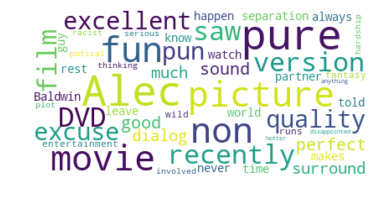

Amazon Review - 3
I had a hard time finding this information when I searched for it, so I thought I'd type it up in case anyone else was wondering what comes free with your new Blu-ray copy of "Beetlejuice":<br /><br />1. Danny Elfman - "Main Titles"<br />2. Danny Elfman - "Enter ... 'The Family'/Sand Worm Planet"<br />3. Danny Elfman - "The Aftermath"<br />4. Danny Elfman - "Showtime!"<br />5. Harry Belafonte - "The Banana Boat Song" (worth the price of the Blu-ray disc itself!)<br />6. Danny Elfman - "End Credits"
****************************************************************************************************


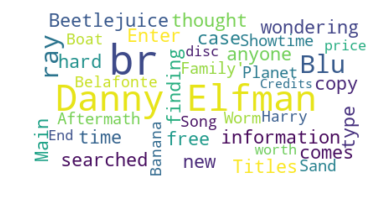

In [86]:
counter = 1;
for i in range(len(cluster_1_tfidf)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_1_tfidf[i])
        print("*"*100)
        cluster_wordcloud(cluster_1_tfidf[i])
    counter +=1

### Cluster 2 Reviews:

Amazon Review - 1
I have a chihuahua that is the pickiest eater in the world!  I could not find any treat that this dog liked.  I finally tried the Pro-Treat Liver treats for dogs and she loves them!!  I actually have to give them to her at different times on different days, or she will get use to when she will get them.  Example, I was giving them to her when I got up every morning, so every morning she would wake me up at like 3:00 am so she could have a treat!<br /><br />These are the best treats and they are good for her!  It's a win win situation!
****************************************************************************************************


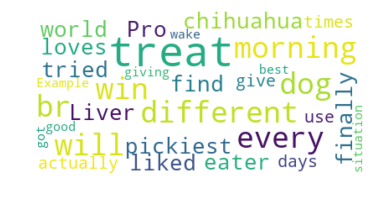

Amazon Review - 2
My two boxes absolutely LOVE these freeze dried liver treats; it is one of their favorites.  Both dogs do their kidney bean dances in the kitchen when we take the lid off.  The only bad thing is the treats are small and they only recommend a few daily.  (But, I guess that's not too much of a bad thing given these are a little pricer than the average dog treat)
****************************************************************************************************


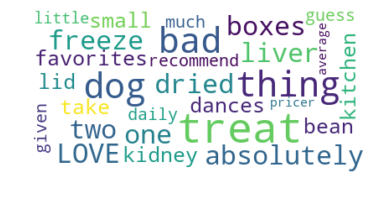

Amazon Review - 3
Our dogs love these treats - last a long time - light and easy to give our dogs.  Amazon has the best price for these treats - will always have them in our house!
****************************************************************************************************


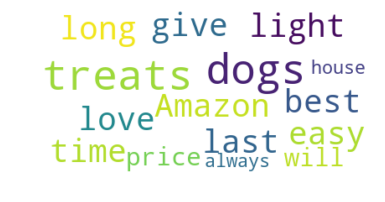

In [87]:
counter = 1;
for i in range(len(cluster_2_tfidf)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_2_tfidf[i])
        print("*"*100)
        cluster_wordcloud(cluster_2_tfidf[i])
    counter +=1

### Cluster 3 Review:

Amazon Review - 1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!
****************************************************************************************************


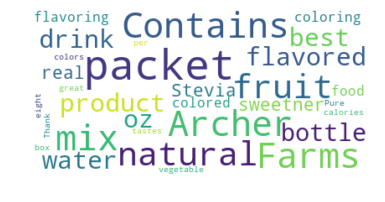

Amazon Review - 2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
****************************************************************************************************


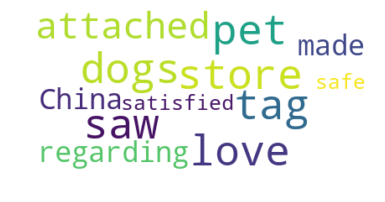

Amazon Review - 3
My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
****************************************************************************************************


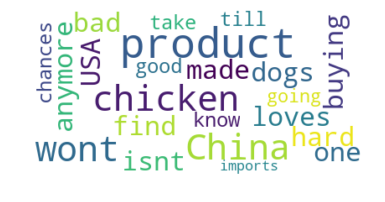

In [88]:
counter = 1;
for i in range(len(cluster_3_tfidf)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_3_tfidf[i])
        print("*"*100)
        cluster_wordcloud(cluster_3_tfidf[i])
    counter +=1

## k-medoids algorithm Implementation


In [89]:
# code reference https://github.com/letiantian/kmedoids
from sklearn.metrics.pairwise import pairwise_distances

X_tfidf_data = X_tfidf[0:10000,:]
D_matrix = pairwise_distances(X_tfidf_data , metric='euclidean')

M_tfidf , C_tfidf = kMedoid(D_matrix , k = optimal_n_clusters_tfidf)

****************************************************************************************************
Cluster -  1
Printing the no of reviews present in each Cluster 1  are =  3142
****************************************************************************************************
Review -  1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


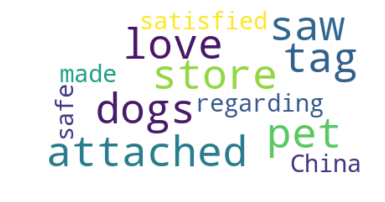

Review -  2
This is one product that my welsh terrier can eat. Sophie has food alergies so I have to be very careful in what I feed her. My other dog Oscar, also gets these treats and loves them. He has no food alergies. This product is just simple ingredients, no additives, and that is what my dogs need.


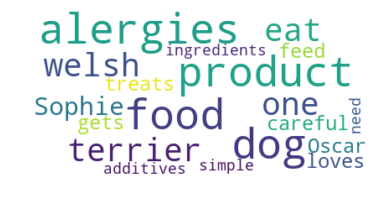



****************************************************************************************************
Cluster -  2
Printing the no of reviews present in each Cluster 2  are =  4213
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


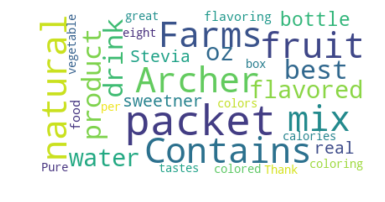

Review -  2
My Westie loves these things!  She loves anything with liver but this one is the best.  Expensive by weight, but well worth it.  The freeze-drying process concentrates the flavor and nutrition:  Susie gives it 5 snouts!


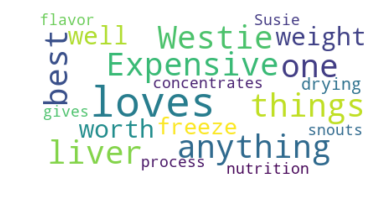



****************************************************************************************************
Cluster -  3
Printing the no of reviews present in each Cluster 3  are =  2645
****************************************************************************************************
Review -  1
My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


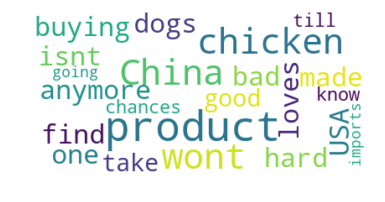

Review -  2
I have been feeding my greyhounds these treats for years.  My hounds can be a little finicky, but they love these treats.  They are expensive, relative to other biscuits, but I find they are a good addition to their diet.  The treats are easy on the teeth.  Since they are protein treat, be careful not to overindulge your pet on a regular basis.  They are great treats to take on walks as you can stuff them in your pocket easily.  I have found prices can vary from vendor to vendor, so shop around.


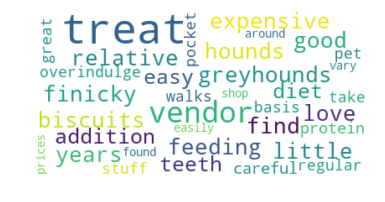

In [90]:
# Getting the reviews in all clusters
for labels in C_tfidf:
    print("*" * 100)
    print("Cluster - ",labels + 1)
    print('Printing the no of reviews present in each Cluster',labels + 1,' are = ',C_tfidf[labels].shape[0])
    print("*" * 100)

    review_counter = 1
    
    for label_index in C_tfidf[labels]:
        if review_counter == 3:
            break;
        else:
            print('Review - ',review_counter)
            print(text_reviews[label_index])
            cluster_wordcloud(text_reviews[label_index])
            review_counter = review_counter+1
    print('\n')

## Word2Vec And Kmeans Implementation:

In [91]:
# Lets compute a list of words for Train Data to compute the word2vec:
# Now we will Train our own model using Word2vec:
list_of_sentence=[]
for sent in X:
    list_of_sentence.append(sent.split())

print(list_of_sentence[0])

['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'movi']


In [92]:
# Creating the gensim model
import gensim
import warnings
warnings.filterwarnings('ignore')

model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=200 , workers=4)
vocab_list = list(model.wv.vocab)

In [93]:
#Computing the Average word2vec for Data:
sent_vect= [] #this will hold the all values of the vectors of each words
for sen in tqdm(list_of_sentence):
    sen_vec = np.zeros(200) 
    word_count=0
    for word in sen:
        if word in vocab_list:
            vector_of_current_word = model.wv[word]
            sen_vec+=vector_of_current_word
            word_count+=1
    if word_count != 0:
        sen_vec/=word_count
    sent_vect.append(sen_vec)

print(len(sent_vect))

print(len(sent_vect[0]))
        

100%|█████████████████████████████████| 100000/100000 [04:04<00:00, 409.68it/s]


100000
200


In [94]:
sent_vect = np.array(sent_vect)
type(sent_vect)

numpy.ndarray

In [95]:
n_clusters_list_w2v = range(1,10)
cluster_inertia_w2v = []

for clusters in tqdm(n_clusters_list_w2v):
    model = KMeans(n_clusters = clusters, n_init=5 , n_jobs=-1)
    model.fit(sent_vect)
    cluster_inertia_w2v.append(model.inertia_)

100%|████████████████████████████████████████████| 9/9 [02:52<00:00, 25.58s/it]


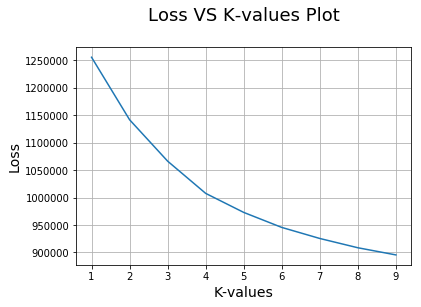

In [96]:
# Draw Loss VS K values plot
plt.plot(n_clusters_list_w2v, cluster_inertia_w2v)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [97]:
#from the plot let's take optimal K value as 3.
optimal_n_clusters_w2v = 3

# Implementing K-Means using optimal value of n_clusters
kmeans_w2v = KMeans(n_clusters=optimal_n_clusters_w2v, n_jobs=-1).fit(sent_vect)
# getting original text i.e review column from the dataset 
text_reviews = final['Text'].values
cluster_1_w2v = []
cluster_2_w2v = []
cluster_3_w2v = []

for i in range(kmeans_w2v.labels_.shape[0]):
    if kmeans_w2v.labels_[i] == 0:
        cluster_1_w2v.append(text_reviews[i])
    elif kmeans_w2v.labels_[i] == 1:
        cluster_2_w2v.append(text_reviews[i])
    else :
        cluster_3_w2v.append(text_reviews[i]) 

## Cluster 1 Reviews:

Amazon Review - 1
I have tried several different kinds of training treats from pet stores and they all either made my English Bulldog puppy sick or lose interest. The liver is working great she absolutely loves them and they keep her attention 100%!
****************************************************************************************************


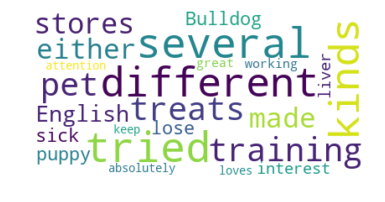

Amazon Review - 2
My dogs love this stuff! They will do anything for liver treats!<br />Be careful, very rich, a little goes a very long way, give sparingly!!!!
****************************************************************************************************


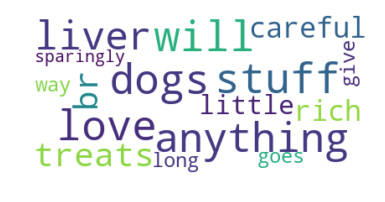

Amazon Review - 3
This is 2.5 oz larger than what you can find in pet stores and less expensive. Shipped day the it was ordered and arrived 2 days later with prime.
****************************************************************************************************


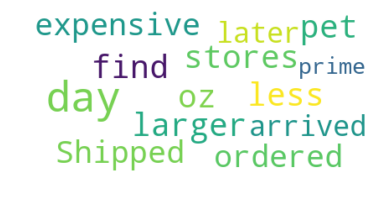

In [98]:
counter = 1;
for i in range(len(cluster_1_w2v)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_1_w2v[i])
        print("*"*100)
        cluster_wordcloud(cluster_1_w2v[i])
    counter +=1

## Cluster 2 Reviews:

Amazon Review - 1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!
****************************************************************************************************


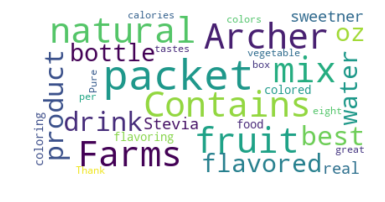

Amazon Review - 2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
****************************************************************************************************


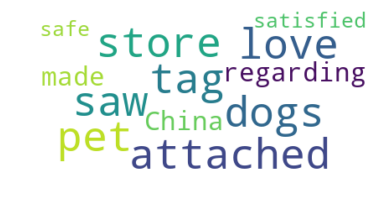

Amazon Review - 3
My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
****************************************************************************************************


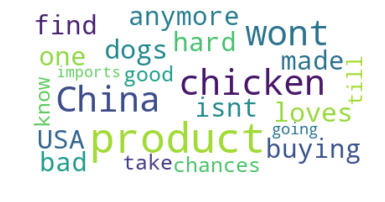

In [99]:
counter = 1;
for i in range(len(cluster_2_w2v)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_2_w2v[i])
        print("*"*100)
        cluster_wordcloud(cluster_2_w2v[i])
    counter +=1

## Cluster 3 Reviews: 

Amazon Review - 1
New puppy loves this, only treat he will pay attention to while walking and training. One note, pieces are quite large so I cut them up into smaller pieces so their recommended daily amount goes further.<br /><br />All the dogs in the dog park can't resist my pocket when I have these treats. Usually surrounded by a crowd of dogs all poking at my pocket.
****************************************************************************************************


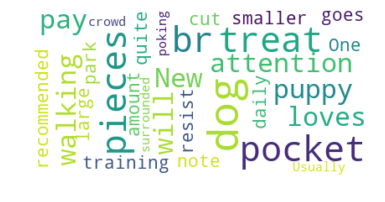

Amazon Review - 2
My dog loves these treats!  We started using them for training purposes.  The treats of healthy too!
****************************************************************************************************


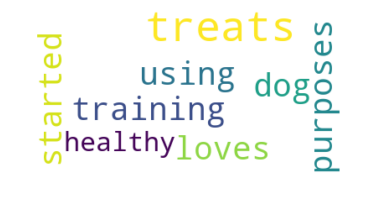

Amazon Review - 3
This is a great treat which all three of my dogs absolutely love!  I am now ordering it regularly and the price is great.
****************************************************************************************************


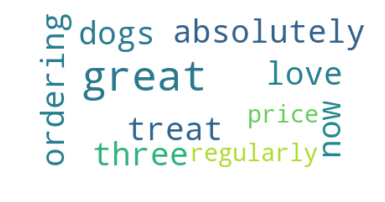

In [115]:
counter = 1;
for i in range(len(cluster_3_w2v)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_3_w2v[i])
        print("*"*100)
        cluster_wordcloud(cluster_3_w2v[i])
    counter +=1

## K-Medoid Implementation on Avg W2V:

In [101]:
# code reference https://github.com/letiantian/kmedoids
from sklearn.metrics.pairwise import pairwise_distances

sent_vect_data = sent_vect[0:10000]
D_matrix = pairwise_distances(sent_vect_data , metric='euclidean')

M_w2v , C_w2v = kMedoid(D_matrix , k = optimal_n_clusters)


****************************************************************************************************
Cluster -  1
Printing the no of reviews present in each Cluster 1  are =  3891
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


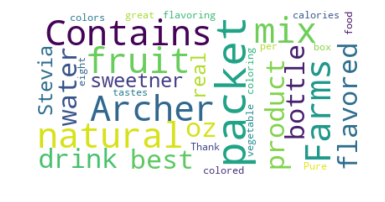

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


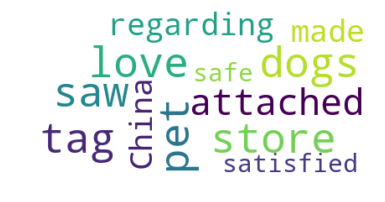



****************************************************************************************************
Cluster -  2
Printing the no of reviews present in each Cluster 2  are =  2289
****************************************************************************************************
Review -  1
I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when g

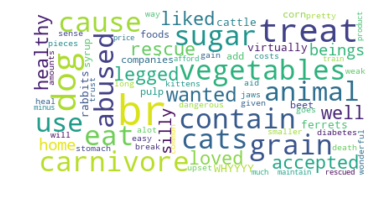

Review -  2
My Westie loves these things!  She loves anything with liver but this one is the best.  Expensive by weight, but well worth it.  The freeze-drying process concentrates the flavor and nutrition:  Susie gives it 5 snouts!


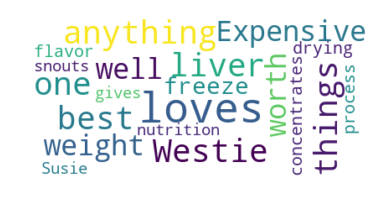



****************************************************************************************************
Cluster -  3
Printing the no of reviews present in each Cluster 3  are =  3820
****************************************************************************************************
Review -  1
My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


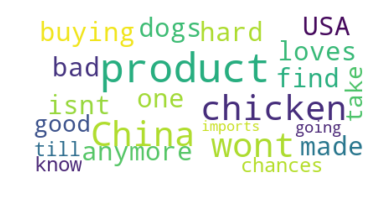

Review -  2
This is one product that my welsh terrier can eat. Sophie has food alergies so I have to be very careful in what I feed her. My other dog Oscar, also gets these treats and loves them. He has no food alergies. This product is just simple ingredients, no additives, and that is what my dogs need.


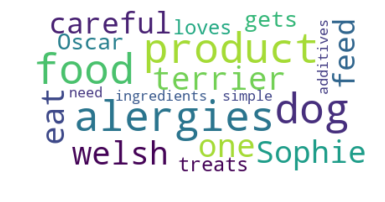

In [102]:
# Getting the reviews in all clusters
for labels in C_w2v:
    print("*" * 100)
    print("Cluster - ",labels + 1)
    print('Printing the no of reviews present in each Cluster',labels + 1,' are = ',C_w2v[labels].shape[0])
    print("*" * 100)

    review_counter = 1
    
    for label_index in C_w2v[labels]:
        if review_counter == 3:
            break;
        else:
            print('Review - ',review_counter)
            print(text_reviews[label_index])
            cluster_wordcloud(text_reviews[label_index])
            review_counter = review_counter+1
    print('\n')

# TF-idf W2vec :

In [103]:
#Computing the TF-idf values for the Train Data:
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(X)

# we are converting a dictionary with word as a key, and the tfidf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [104]:
# Creating the gensim model
model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=200 , workers=4)
vocab_list = list(model.wv.vocab)

In [105]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab_list:
            vec = model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print('\n' , len(tfidf_sent_vectors))

print(len(tfidf_sent_vectors[0]))

100%|█████████████████████████████████| 100000/100000 [04:49<00:00, 345.80it/s]



 100000
200


In [106]:
#Converting the type of tfidf_sent_vectors_train to ndarray:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
type(tfidf_sent_vectors)

numpy.ndarray

In [107]:
n_clusters_list_tfidf_w2v = range(1,10)
cluster_inertia_tfidf_w2v = []

for clusters in tqdm(n_clusters_list_tfidf_w2v):
    model = KMeans(n_clusters = clusters, n_init=5 , n_jobs=-1)
    model.fit(tfidf_sent_vectors)
    cluster_inertia_tfidf_w2v.append(model.inertia_)

100%|████████████████████████████████████████████| 9/9 [02:45<00:00, 24.01s/it]


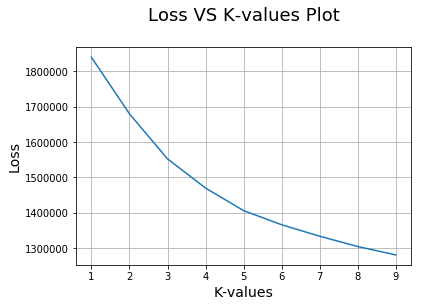

In [108]:
# Draw Loss VS K values plot
plt.plot(n_clusters_list_tfidf_w2v, cluster_inertia_tfidf_w2v)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [109]:
optimal_n_clusters_tfidf_w2v = 3

# Implementing K-Means using optimal value of n_clusters
kmeans_tfidf_w2v = KMeans(n_clusters=optimal_n_clusters_tfidf_w2v, n_jobs=-1).fit(tfidf_sent_vectors)
# getting original text i.e review column from the dataset 
text_reviews = final['Text'].values
cluster_1_tfidf_w2v = []
cluster_2_tfidf_w2v = []
cluster_3_tfidf_w2v = []

for i in range(kmeans_tfidf_w2v.labels_.shape[0]):
    if kmeans_tfidf_w2v.labels_[i] == 0:
        cluster_1_tfidf_w2v.append(text_reviews[i])
    elif kmeans_tfidf_w2v.labels_[i] == 1:
        cluster_2_tfidf_w2v.append(text_reviews[i])
    else :
        cluster_3_tfidf_w2v.append(text_reviews[i]) 

## Cluster-1 Review:

Amazon Review - 1
No waste , even if she is having a  day when she goes on a hunger strike  she always room for one or 2 or 3 of these and the extra powder on bottom makes a real treat on food , Never met a pooch that did not go crazy over her treats !
****************************************************************************************************


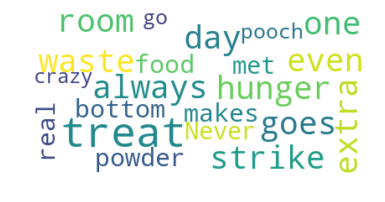

Amazon Review - 2
New puppy loves this, only treat he will pay attention to while walking and training. One note, pieces are quite large so I cut them up into smaller pieces so their recommended daily amount goes further.<br /><br />All the dogs in the dog park can't resist my pocket when I have these treats. Usually surrounded by a crowd of dogs all poking at my pocket.
****************************************************************************************************


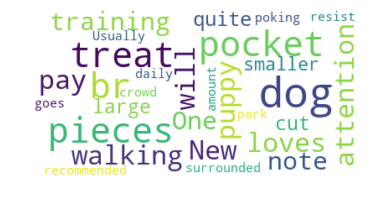

Amazon Review - 3
My dog loves these treats!  We started using them for training purposes.  The treats of healthy too!
****************************************************************************************************


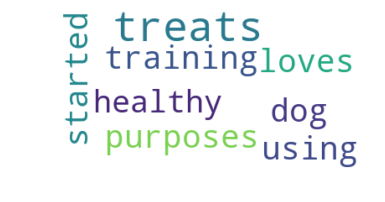

In [110]:
counter = 1;
for i in range(len(cluster_1_tfidf_w2v)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_1_tfidf_w2v[i])
        print("*"*100)
        cluster_wordcloud(cluster_1_tfidf_w2v[i])
    counter +=1

## Cluster-2 Review:

Amazon Review - 1
I have tried several different kinds of training treats from pet stores and they all either made my English Bulldog puppy sick or lose interest. The liver is working great she absolutely loves them and they keep her attention 100%!
****************************************************************************************************


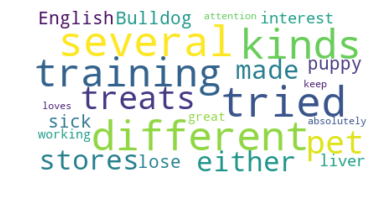

Amazon Review - 2
My dogs love this stuff! They will do anything for liver treats!<br />Be careful, very rich, a little goes a very long way, give sparingly!!!!
****************************************************************************************************


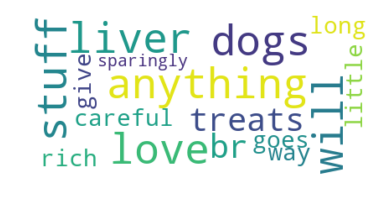

Amazon Review - 3
My three very finicky dogs love this product, and I like the way I can cut them up into small pieces for training.  There is only one ingredient in this: liver, all sourced within the United States, so I feel confident and safe giving this to my dogs.  I buy this on a regular basis.  It's priced better than any pet supply store I've seen, even the larger chains.  Qualifies for free shipping, which is also nice.
****************************************************************************************************


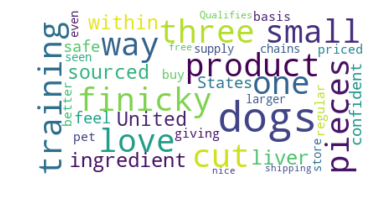

In [111]:
counter = 1;
for i in range(len(cluster_2_tfidf_w2v)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_2_tfidf_w2v[i])
        print("*"*100)
        cluster_wordcloud(cluster_2_tfidf_w2v[i])
    counter +=1

## Cluster-3 Review:

Amazon Review - 1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!
****************************************************************************************************


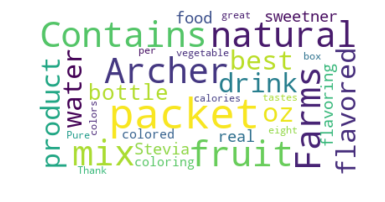

Amazon Review - 2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
****************************************************************************************************


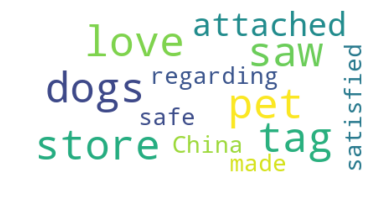

Amazon Review - 3
My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
****************************************************************************************************


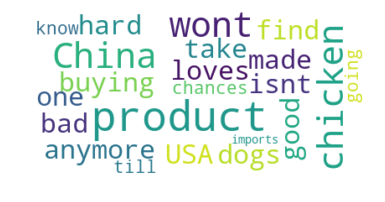

In [112]:
counter = 1;
for i in range(len(cluster_3_tfidf_w2v)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster_3_tfidf_w2v[i])
        print("*"*100)
        cluster_wordcloud(cluster_3_tfidf_w2v[i])
    counter +=1

## K-Medoid Implementation on Tfidf-Avg W2v :

In [113]:
# code reference https://github.com/letiantian/kmedoids
from sklearn.metrics.pairwise import pairwise_distances

tfidf_sent_vectors_data = tfidf_sent_vectors[0:10000]
D_matrix = pairwise_distances(tfidf_sent_vectors_data , metric='euclidean')

M_tfidf_w2v , C_tfidf_w2v = kMedoid(D_matrix , k = optimal_n_clusters_tfidf_w2v)

****************************************************************************************************
Cluster -  1
Printing the no of reviews present in each Cluster 1  are =  5409
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


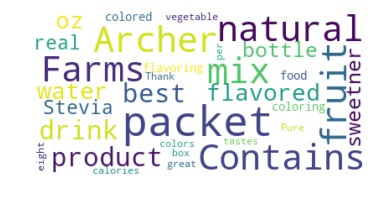

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


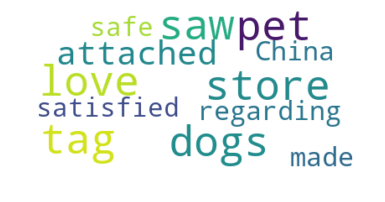



****************************************************************************************************
Cluster -  2
Printing the no of reviews present in each Cluster 2  are =  3063
****************************************************************************************************
Review -  1
My dog is not enthusiastic about food.  She enjoys these treats which are light weight and easy to carry.  Number of treats per day must be limited.


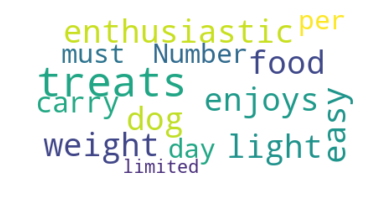

Review -  2
We tried everything including cheese, chicken & hot dogs and this is the only one he will eat.


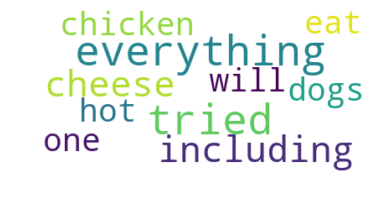



****************************************************************************************************
Cluster -  3
Printing the no of reviews present in each Cluster 3  are =  1528
****************************************************************************************************
Review -  1
I have tried several different kinds of training treats from pet stores and they all either made my English Bulldog puppy sick or lose interest. The liver is working great she absolutely loves them and they keep her attention 100%!


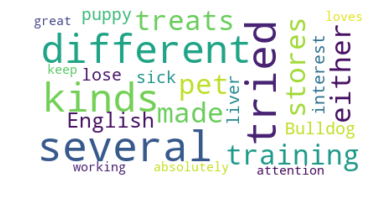

Review -  2
My dogs love this stuff! They will do anything for liver treats!<br />Be careful, very rich, a little goes a very long way, give sparingly!!!!


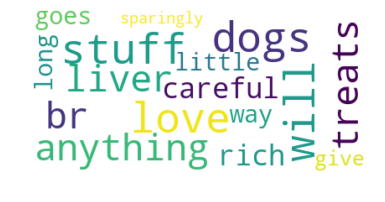

In [114]:
# Getting the reviews in all clusters
for labels in C_tfidf_w2v:
    print("*" * 100)
    print("Cluster - ",labels + 1)
    print('Printing the no of reviews present in each Cluster',labels + 1,' are = ',C_tfidf_w2v[labels].shape[0])
    print("*" * 100)

    review_counter = 1
    
    for label_index in C_tfidf_w2v[labels]:
        if review_counter == 3:
            break;
        else:
            print('Review - ',review_counter)
            print(text_reviews[label_index])
            cluster_wordcloud(text_reviews[label_index])
            review_counter = review_counter+1
    print('\n')